In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
PATH_OF_DATA = '/content/gdrive/MyDrive/images'

In [ ]:
import shutil
import pandas as pd
import numpy as np
import os
import math
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
os.chdir(PATH_OF_DATA)
category_list = list(filter(lambda x: os.path.isdir(x), os.listdir()))
for category in category_list:
  print(category)

Chilli
Bitter gourd
Lime
Mature tea tree
White Gigantic swallow wort
Ground nut
Wood-apple
Banana pepper


In [ ]:
data_set_dirs= ['train','test']
for dsdirs in data_set_dirs:
  path = PATH_OF_DATA + '/'+ dsdirs
  os.mkdir( path,755 )

In [ ]:
train_prop = 0.7

In [ ]:
def create_dataset():
  for ii,cat in enumerate(category_list):    
    src_path = PATH_OF_DATA + '/' + cat
    dest_dir1 = PATH_OF_DATA+'/train/'+str(ii)
    dest_dir2 = PATH_OF_DATA+'/test/'+str(ii)
    
    dest_dirs_list = [dest_dir1,dest_dir2]
    for dirs in dest_dirs_list:
      os.mkdir(dirs,755 )
    
    #get files' names list from respective directories
    os.chdir(src_path)
    files = [f for f in os.listdir() if os.path.isfile(f)]
    
    #get training, testing  files count
    train_count = math.ceil(train_prop*len(files))
    test_count = int((len(files)-train_count)/2)
    
    #get files to segragate for train,test data set
    train_data_list = files[0: train_count] 
    test_data_list =  files[train_count+test_count:]
       
  
    for train_data in train_data_list:
      train_path = src_path + '/' + train_data
      shutil.copy(train_path,dest_dir1)
    
    for test_data in test_data_list:
      test_path = src_path + '/' + test_data
      shutil.copy(test_path,dest_dir2)    
    
create_dataset()

In [ ]:
train_dir = '/content/gdrive/MyDrive/images/train'

test_dir = '/content/gdrive/MyDrive/images/test'

In [107]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 32, target_size = (224, 224), color_mode='rgb', 
                                                    classes=None, class_mode='categorical', shuffle=True, seed=None, interpolation="nearest")

test_generator = test_datagen.flow_from_directory( test_dir, batch_size = 32, target_size = (224, 224))

test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


Found 211 images belonging to 8 classes.
Found 43 images belonging to 8 classes.


In [108]:
len(train_generator), len(test_generator)

(7, 2)

In [109]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

In [110]:
base_model.load_weights("/content/gdrive/My Drive/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [111]:
for layer in base_model.layers:
    layer.trainable = False

In [112]:
num_classes = 8

In [122]:
import keras.backend as K

def recall_m(y_true, y_pred):
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
     recall = true_positives / (possible_positives + K.epsilon())
     return recall

In [123]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [115]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [116]:
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D

In [117]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)

In [ ]:
from keras.callbacks import Callback

class LRFinder(Callback):
  def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
  def clr(self):
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
  def on_train_begin(self, logs=None):
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
  def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
  def plot_lr(self):
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
  def plot_loss(self):
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()

In [ ]:
epoch_size = 25
batch_size = 32

In [ ]:
lr_finder = LRFinder(min_lr=1e-5, max_lr=1e-2, steps_per_epoch=np.ceil(epoch_size/batch_size), epochs=3)

In [118]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr = 1e-3, decay = 1e-3/20)

In [124]:
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['acc', f1_m, precision_m, recall_m])

In [125]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 15)
cb_checkpointer = ModelCheckpoint(filepath = '/content/gdrive/My Drive/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [126]:
resnet_history = model.fit(train_generator, validation_data = test_generator, epochs = 25, 
                           steps_per_epoch=train_generator.samples/train_generator.batch_size,
                           validation_steps=test_generator.samples/test_generator.batch_size,
                           callbacks=[cb_checkpointer, cb_early_stopper])

model.load_weights("/content/gdrive/My Drive/best.hdf5")

Epoch 1/25
6/6 [==============================] - 102s 15s/step - loss: 2.4193 - acc: 0.1850 - f1_m: 0.1029 - precision_m: 0.2722 - recall_m: 0.0676 - val_loss: 1.9814 - val_acc: 0.2558 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/25
6/6 [==============================] - 91s 14s/step - loss: 2.2892 - acc: 0.1756 - f1_m: 0.0685 - precision_m: 0.3575 - recall_m: 0.0383 - val_loss: 1.8283 - val_acc: 0.2791 - val_f1_m: 0.3224 - val_precision_m: 0.9000 - val_recall_m: 0.1989
Epoch 3/25
6/6 [==============================] - 91s 14s/step - loss: 2.0189 - acc: 0.2523 - f1_m: 0.1937 - precision_m: 0.7861 - recall_m: 0.1126 - val_loss: 1.7438 - val_acc: 0.3256 - val_f1_m: 0.2854 - val_precision_m: 0.9167 - val_recall_m: 0.1690
Epoch 4/25
6/6 [==============================] - 91s 14s/step - loss: 1.8718 - acc: 0.3076 - f1_m: 0.1863 - precision_m: 0.9768 - recall_m: 0.1080 - val_loss: 1.7184 - val_acc: 0.3023 - val_f1_m: 0.1750 - val_precision_m: 0.437

In [127]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[1.5128626823425293,
 0.5813953280448914,
 0.285425066947937,
 0.9166666269302368,
 0.16903409361839294]

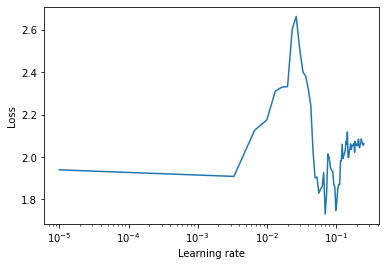

In [ ]:
lr_finder.plot_loss()

In [128]:
predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [129]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

In [130]:
import sklearn.metrics as metrics


report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.08      0.14      0.11         7
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.25      0.29      0.27         7
           7       0.17      0.50      0.25         6

    accuracy                           0.14        43
   macro avg       0.06      0.12      0.08        43
weighted avg       0.08      0.14      0.10        43



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
plt.plot

<function matplotlib.pyplot.plot>

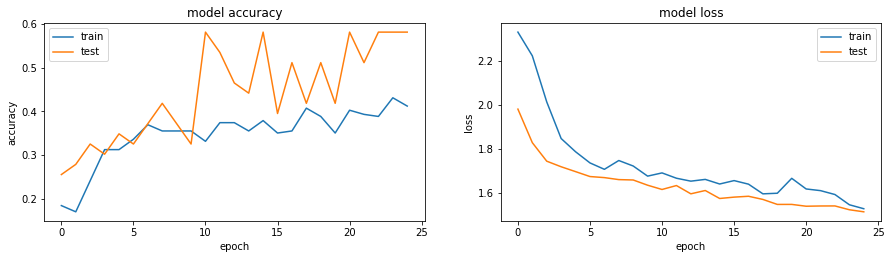

In [132]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(resnet_history.history['acc'])  
plt.plot(resnet_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 
    
plt.subplot(222)  
plt.plot(resnet_history.history['loss'])  
plt.plot(resnet_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 

plt.show()

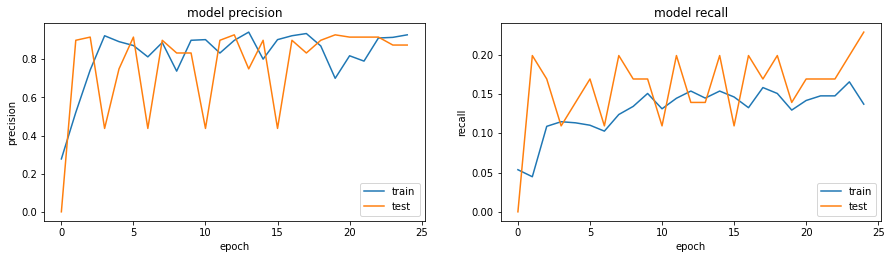

In [135]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(resnet_history.history['precision_m'])  
plt.plot(resnet_history.history['val_precision_m'])  
plt.title('model precision')  
plt.ylabel('precision')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 

plt.subplot(222)  
plt.plot(resnet_history.history['recall_m'])  
plt.plot(resnet_history.history['val_recall_m'])  
plt.title('model recall')  
plt.ylabel('recall')  
plt.xlabel('epoch')  
plt.legend(['train', 'test']) 

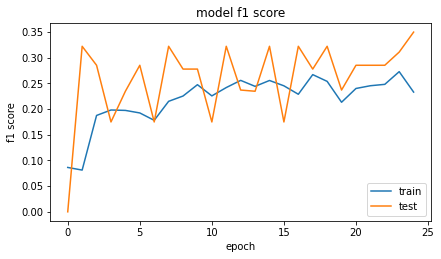

In [136]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(resnet_history.history['f1_m'])  
plt.plot(resnet_history.history['val_f1_m'])  
plt.title('model f1 score')  
plt.ylabel('f1 score')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________